# 70 · NLP Email Anomalies
        
        Detect phishing/abuse emails with a baseline TF-IDF + logistic regression model.
        - Build a labeled dataset from the Kaggle Fake/Real news dump.
        - Inspect class balance and sample messages.
        - Train the baseline used elsewhere in the codebase.


In [5]:
from pathlib import Path
import sys
import pandas as pd
import matplotlib.pyplot as plt

project_root = Path('..').resolve()
src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from uais.nlp.train_text_classifier import NLPConfig, run_text_experiment
print('Project root:', project_root)


Project root: /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence


In [ ]:
# Load all NLP CSVs under data/raw/nlp if present, else fall back to Fake/True build
from uais.data.load_datasets import load_nlp_data
try:
    df = load_nlp_data()
    print('Loaded aggregated NLP data:', df.shape)
except Exception as exc:
    print('Aggregated NLP load failed, falling back to Fake/True build:', exc)
    # existing build will populate df


In [6]:
# Build labeled Fake/True dataset (downloaded via KaggleHub)
fake_root = project_root / 'data' / 'raw' / 'nlp' / 'fakenews' / 'datasets' / 'clmentbisaillon' / 'fake-and-real-news-dataset' / 'versions' / '1'
fake_path = fake_root / 'Fake.csv'
true_path = fake_root / 'True.csv'
if not (fake_path.exists() and true_path.exists()):
    raise FileNotFoundError(f'Missing Fake/True news CSVs under {fake_root}')

df = (
    pd.concat([pd.read_csv(fake_path).assign(label=1), pd.read_csv(true_path).assign(label=0)], ignore_index=True)
    .rename(columns={'text': 'content'})[['content', 'label']]
)
print('Rows:', len(df), ' | Columns:', list(df.columns))
print(df.head())

# Persist combined CSV for reuse
out_csv = project_root / 'data' / 'raw' / 'nlp' / 'fakenews' / 'fake_news_labeled.csv'
out_csv.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(out_csv, index=False)


Rows: 44898  | Columns: ['content', 'label']
                                             content  label
0  Donald Trump just couldn t wish all Americans ...      1
1  House Intelligence Committee Chairman Devin Nu...      1
2  On Friday, it was revealed that former Milwauk...      1
3  On Christmas day, Donald Trump announced that ...      1
4  Pope Francis used his annual Christmas Day mes...      1


## Data cleaning
Remove duplicates/empty texts and standardize the content field before training.

In [ ]:
before = len(df)
# Ensure text is string and stripped
if 'content' in df.columns:
    df['content'] = df['content'].astype(str).str.strip()

# Drop rows with missing/empty text or label
if 'content' in df.columns:
    df = df[df['content'].notna()]
    df = df[df['content'] != '']
if 'label' in df.columns:
    df = df[df['label'].notna()]

# Drop duplicate text/label pairs
if 'content' in df.columns and 'label' in df.columns:
    df = df.drop_duplicates(subset=['content', 'label']).reset_index(drop=True)
else:
    df = df.drop_duplicates().reset_index(drop=True)

print(f"Rows before cleaning: {before}, after: {len(df)}")
print('Nulls by column:
', df.isna().sum())


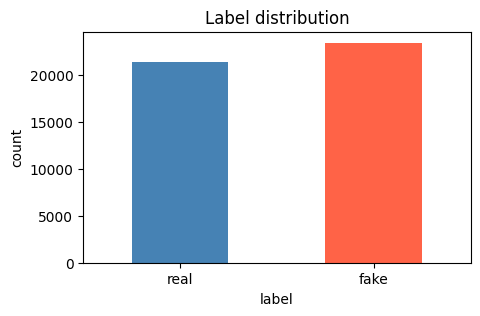

Sample texts:
                                                 content  label
22216  21st Century Wire says Ben Stein, reputable pr...      1
27917  WASHINGTON (Reuters) - U.S. President Donald T...      0
25007  (Reuters) - Puerto Rico Governor Ricardo Rosse...      0


In [7]:
# Class balance
counts = df['label'].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(5,3))
counts.plot(kind='bar', ax=ax, color=['steelblue','tomato'])
ax.set_xticklabels(['real','fake'], rotation=0)
ax.set_ylabel('count')
ax.set_title('Label distribution')
plt.show()

print('Sample texts:')
print(df.sample(3, random_state=42))


In [8]:
# Train baseline TF-IDF + logistic regression
config = NLPConfig(
    dataset_path=out_csv,
    text_column='content',
    label_column='label',
    model_name='distilbert-base-uncased',
)
results = run_text_experiment(config)
print('Metrics:', results)


Model: distilbert-base-uncased
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       949
           1       0.98      0.97      0.98      1051

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000

Metrics: {'roc_auc': 0.9947483404334675, 'accuracy': 0.9755}
